# Big Data Management Project 4:
## Airline Delay and Cancellation Prediction with Spark ML


### Imports & Setup

### 1. Data Ingestion and Preparation

In [8]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("BDM_Project4") \
    .getOrCreate()

In [10]:
df2009 = (spark.read
      .option("header", "true")
      .option("inferSchema", "true")
      .csv("input/2009.csv"))
df2009.printSchema()
df2009.show(5)

root
 |-- FL_DATE: date (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: doub

#### Save as parquet, partitioned by extracted month

In [11]:
from pyspark.sql.functions import col, month, dayofweek

df2009 = df2009.withColumn("Month", month(col("FL_DATE")))
df2009 = df2009.withColumn("DayOfWeek", dayofweek(col("FL_DATE")))
df2009.write.mode("overwrite").partitionBy("Month").parquet("/home/jovyan/input/2009_parquet/")

### 2. Cleaning and Preprocessing

In [4]:
df2009 = df2009.drop("Unnamed: 27")

df2009 = df2009.withColumnRenamed("OP_CARRIER", "UniqueCarrier")
df2009 = df2009.withColumnRenamed("OP_CARRIER_FL_NUM", "UniqueCarrierFlightNumber")

df2009_cleaned = df2009.dropna(subset=['FL_DATE', 'UniqueCarrier'])

df2009_cleaned = df2009_cleaned.filter(col("DIVERTED") == 0.0)

df2009_cleaned = df2009_cleaned.withColumn("Month", month("FL_DATE")) \
                                 .withColumn("DayOfWeek", dayofweek("FL_DATE"))

### 3. Exploratory Analysis

In [12]:
df2009_cleaned.groupBy("CANCELLED").count().show()

+---------+------+
|CANCELLED| count|
+---------+------+
|      0.0|390415|
|      1.0|  7698|
+---------+------+



In [13]:
cancelled = df2009_cleaned.filter(df2009_cleaned["CANCELLED"] == 1.0)
cancelled.count()

7698

In [14]:
# Top 10 carriers by number of flights
top_10_carriers = cancelled.groupBy("UniqueCarrier").count().orderBy("count", ascending=False).limit(10)
top_10_carriers.show()

+-------------+-----+
|UniqueCarrier|count|
+-------------+-----+
|           OO| 1003|
|           WN|  983|
|           AA|  976|
|           MQ|  781|
|           UA|  557|
|           EV|  502|
|           US|  434|
|           XE|  414|
|           9E|  363|
|           DL|  357|
+-------------+-----+



In [15]:
# Count cancellation reasons
cancel_reasons = cancelled.groupBy("CANCELLATION_CODE").count().orderBy("count", ascending=False)
cancel_reasons.show()

+-----------------+-----+
|CANCELLATION_CODE|count|
+-----------------+-----+
|                B| 3383|
|                A| 3105|
|                C| 1210|
+-----------------+-----+



From Kaggle:
Reason for Cancellation of flight:
- A - Airline/Carrier;
- B - Weather;
- C - National Air System;
- D - Security

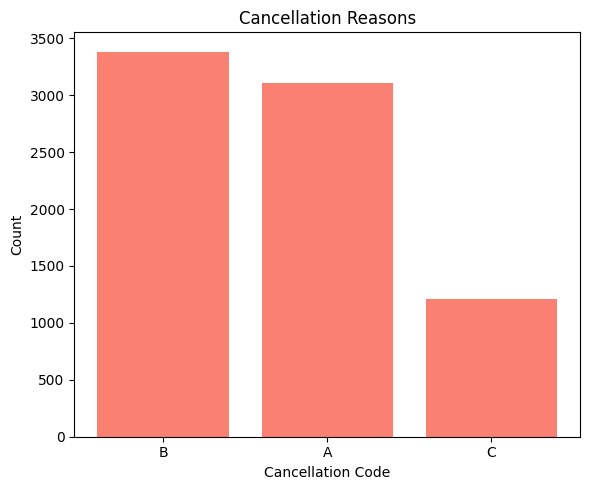

In [16]:
import matplotlib.pyplot as plt
cancel_reasons_pd = cancel_reasons.toPandas()

plt.figure(figsize=(6,5))
plt.bar(cancel_reasons_pd["CANCELLATION_CODE"], cancel_reasons_pd["count"], color='salmon')
plt.xlabel("Cancellation Code")
plt.ylabel("Count")
plt.title("Cancellation Reasons")
plt.tight_layout()
plt.show()

In [17]:
from pyspark.sql.functions import concat_ws

df2009_cleaned.withColumn("Route", concat_ws("->", "ORIGIN", "DEST")) \
               .groupBy("Route").count().orderBy("count", ascending=False).show(10)

+--------+-----+
|   Route|count|
+--------+-----+
|OGG->HNL|  829|
|HNL->OGG|  807|
|SFO->LAX|  762|
|LAX->SFO|  721|
|HNL->LIH|  685|
|BOS->LGA|  672|
|LGA->BOS|  672|
|LGA->ORD|  665|
|LIH->HNL|  662|
|SAN->LAX|  661|
+--------+-----+
only showing top 10 rows



In [18]:
class_dist = df2009_cleaned.groupBy("CANCELLED").count()
class_dist.show()

counts = class_dist.collect()
class_counts = {row['CANCELLED']: row['count'] for row in counts}

imbalance_ratio = max(class_counts.values()) / min(class_counts.values())
print(f"Imbalance Ratio: {imbalance_ratio:.2f}")

+---------+------+
|CANCELLED| count|
+---------+------+
|      0.0|390415|
|      1.0|  7698|
+---------+------+

Imbalance Ratio: 50.72


### 4. Feature Engineering

Categorical features (UniqueCarrier, ORIGIN, DEST) were encoded using StringIndexer and OneHotEncoder. Numerical features (DEP_DELAY, ARR_DELAY, CRS_ELAPSED_TIME) were included directly. All features were combined into a single vector with VectorAssembler for use in modeling.

In [19]:
# === 4. Feature Engineering === Eidi

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

cat_cols = ["UniqueCarrier", "ORIGIN", "DEST"]
# DEP_DELAY ja ARR_DELAY jätsin välja, kuna need veerud sisaldavad
#tühistatud lendude (CANCELLED = 1.0) puhul puuduvaid väärtusi.
# Kui need jätta sisse, siis VectorAssembler
# df_prepared_clean = df_prepared.dropna(subset=assembler_inputs + ["CANCELLED"])
#viskab need read välja (Eemalab kõik read, kus mõni
#VectorAssembler sisend või 'CANCELLED' on null."
# Mudel ei saa õppida tühistatud lendude pealt.
# Kasutasin ainult CRS_ELAPSED_TIME, mis on kõigi lendude puhul olemas.
# ehk siis tehtniliselt, siia peab vaatama veerunimesid mille puhul
# tunnused oleks kõigi lendue puhul ka olemas, mitte null valuga
num_cols = ["CRS_ELAPSED_TIME", "CRS_DEP_TIME", "CRS_ARR_TIME"]


indexers = [StringIndexer(inputCol=col, outputCol=col + "_Index", handleInvalid="keep") for col in cat_cols]
encoders = [OneHotEncoder(inputCol=col + "_Index", outputCol=col + "_Vec", handleInvalid="keep") for col in cat_cols]

assembler_inputs = [col + "_Vec" for col in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features", handleInvalid="skip")

pipeline = Pipeline(stages=indexers + encoders + [assembler])

pipeline_model = pipeline.fit(df2009_cleaned)
df_prepared = pipeline_model.transform(df2009_cleaned)

df_prepared_clean = df_prepared.dropna(subset=assembler_inputs + ["CANCELLED"])

df_prepared_clean.select("features", "CANCELLED").show(5, truncate=False)

+--------------------------------------------------------------+---------+
|features                                                      |CANCELLED|
+--------------------------------------------------------------+---------+
|(583,[7,41,312,580,581,582],[1.0,1.0,1.0,62.0,1100.0,1202.0]) |0.0      |
|(583,[7,32,328,580,581,582],[1.0,1.0,1.0,82.0,1510.0,1632.0]) |0.0      |
|(583,[7,32,321,580,581,582],[1.0,1.0,1.0,70.0,1100.0,1210.0]) |0.0      |
|(583,[7,41,312,580,581,582],[1.0,1.0,1.0,77.0,1240.0,1357.0]) |0.0      |
|(583,[7,48,312,580,581,582],[1.0,1.0,1.0,105.0,1715.0,1900.0])|0.0      |
+--------------------------------------------------------------+---------+
only showing top 5 rows



In [20]:
df2009_cleaned.filter("CANCELLED = 1.0").select("CRS_ELAPSED_TIME", "CRS_DEP_TIME", "CRS_ARR_TIME").summary("count").show()

+-------+----------------+------------+------------+
|summary|CRS_ELAPSED_TIME|CRS_DEP_TIME|CRS_ARR_TIME|
+-------+----------------+------------+------------+
|  count|            7698|        7698|        7698|
+-------+----------------+------------+------------+



In [21]:
df_prepared.filter("CANCELLED = 1.0").select(*assembler_inputs).summary("count").show()

+-------+----------------+------------+------------+
|summary|CRS_ELAPSED_TIME|CRS_DEP_TIME|CRS_ARR_TIME|
+-------+----------------+------------+------------+
|  count|            7698|        7698|        7698|
+-------+----------------+------------+------------+



In [22]:
df_prepared_clean.groupBy("CANCELLED").count().show()

+---------+------+
|CANCELLED| count|
+---------+------+
|      0.0|390415|
|      1.0|  7698|
+---------+------+



In [51]:
#seda osa pole enam vaja tegelt võib ära kustutada

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline


cat_cols = ["UniqueCarrier", "ORIGIN", "DEST"]
indexers = [StringIndexer(inputCol=col, outputCol=col + "_Index") for col in cat_cols]
encoders = [OneHotEncoder(inputCol=col + "_Index", outputCol=col + "_Vec") for col in cat_cols]


num_cols = ["DEP_DELAY", "ARR_DELAY", "CRS_ELAPSED_TIME"]


assembler_inputs = [col + "_Vec" for col in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")


# Pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler])
pipeline_model = pipeline.fit(df2009_cleaned)
df_prepared = pipeline_model.transform(df2009_cleaned)


df_prepared.select("features", "CANCELLED").show(5, truncate=False)


In [23]:
df_prepared.describe()
df_prepared.show()

+----------+-------------+-------------------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----+---------+-------------------+------------+----------+-----------------+----------------+----------------+--------------------+
|   FL_DATE|UniqueCarrier|UniqueCarrierFlightNumber|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Month|DayOfWeek|UniqueCarrier_Index|ORIGIN_Index|DEST_Index|UniqueCarrier_Vec|      ORIGIN_Vec|        DEST_Vec|            features|
+----------+-------------+-------------------------+------+----+------

### 5. Modeling

In [24]:
#5 modeling eidi
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Split the data into train and test sets
train_data, test_data = df_prepared.randomSplit([0.7, 0.3], seed=42)

#defining models
# Logistic Regression
lr = LogisticRegression(labelCol="CANCELLED", featuresCol="features")

# Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="CANCELLED", featuresCol="features")

# Random Forest Classifier
rf = RandomForestClassifier(labelCol="CANCELLED", featuresCol="features")

# Gradient-Boosted Tree Classifier
gbt = GBTClassifier(labelCol="CANCELLED", featuresCol="features")

In [25]:
# 3.evaluators eidi
evaluator_auc = BinaryClassificationEvaluator(labelCol="CANCELLED", metricName="areaUnderROC")
evaluator_acc = MulticlassClassificationEvaluator(labelCol="CANCELLED", metricName="accuracy")

In [26]:
# 4. Define parameter grids eidi
lr_grid = ParamGridBuilder().addGrid(lr.maxIter, [10, 50]).build()
dt_grid = ParamGridBuilder().addGrid(dt.maxDepth, [5, 10]).build()
rf_grid = ParamGridBuilder().addGrid(rf.numTrees, [10, 50]).build()
gbt_grid = ParamGridBuilder().addGrid(gbt.maxIter, [10, 50]).build()

In [27]:
# 5. CrossValidators eidi
cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=lr_grid, evaluator=evaluator_auc, numFolds=3)
cv_dt = CrossValidator(estimator=dt, estimatorParamMaps=dt_grid, evaluator=evaluator_auc, numFolds=3)
cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=rf_grid, evaluator=evaluator_auc, numFolds=3)
cv_gbt = CrossValidator(estimator=gbt, estimatorParamMaps=gbt_grid, evaluator=evaluator_auc, numFolds=3)

In [28]:
# 6. Train models eidi
lr_model = cv_lr.fit(train_data)
dt_model = cv_dt.fit(train_data)
rf_model = cv_rf.fit(train_data)
gbt_model = cv_gbt.fit(train_data)

In [29]:
# 7. predictions eidi
lr_pred = lr_model.transform(test_data)
dt_pred = dt_model.transform(test_data)
rf_pred = rf_model.transform(test_data)
gbt_pred = gbt_model.transform(test_data)

In [30]:
# 8. Evaluate eidi
results = []

def evaluate_model(name, predictions):
    accuracy = evaluator_acc.evaluate(predictions)
    auc = evaluator_auc.evaluate(predictions)
    results.append({"Model": name, "Accuracy": accuracy, "AUC": auc})
    print(f"{name} — Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

evaluate_model("Logistic Regression", lr_pred)
evaluate_model("Decision Tree", dt_pred)
evaluate_model("Random Forest", rf_pred)
evaluate_model("Gradient Boosted Trees", gbt_pred)

import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

Logistic Regression — Accuracy: 0.9802, AUC: 0.7467
Decision Tree — Accuracy: 0.9801, AUC: 0.4336
Random Forest — Accuracy: 0.9802, AUC: 0.6384
Gradient Boosted Trees — Accuracy: 0.9802, AUC: 0.7131
                    Model  Accuracy       AUC
0     Logistic Regression  0.980154  0.746740
1           Decision Tree  0.980112  0.433576
2           Random Forest  0.980196  0.638445
3  Gradient Boosted Trees  0.980188  0.713094


### 6. Explainability

In [38]:
# AUC mõhjal on log reg parim
best_tree_model = gbt_model.bestModel  # või gbt
importances = best_tree_model.featureImportances

In [32]:
feature_names = assembler.getInputCols()

In [33]:
feature_importance_list = list(zip(feature_names, importances))
sorted_features = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)

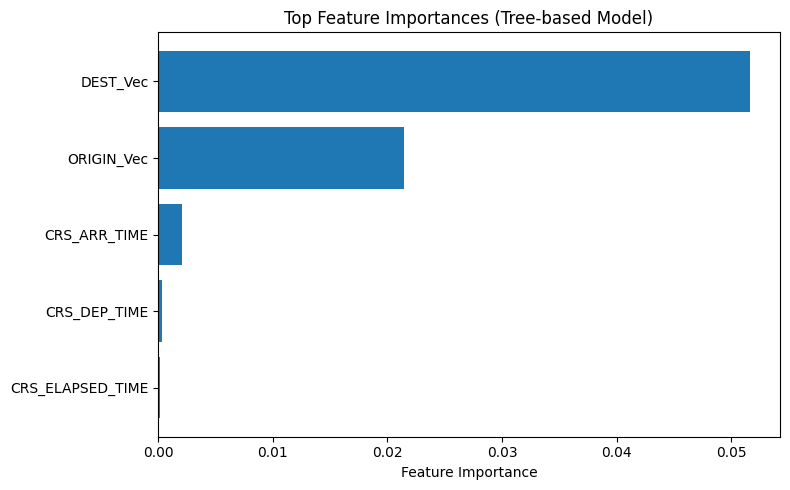

In [49]:
import matplotlib.pyplot as plt

top_k = 5
top_features = sorted_features[:top_k]

names = [f[0] for f in top_features]
scores = [f[1] for f in top_features]

plt.figure(figsize=(8, 5))
plt.barh(names[::-1], scores[::-1])
plt.xlabel("Feature Importance")
plt.title("Top Feature Importances (Tree-based Model)")
plt.tight_layout()
plt.show()

### 7. Model Persistence and Inference

In [50]:
# 8. Loo täispipeline (feature pipeline + parim mudel)
full_pipeline = Pipeline(stages=pipeline_model.stages + [lr_model.bestModel])
full_pipeline_model = full_pipeline.fit(df2009_cleaned)

# 9. Salvesta täispipeline (model + feature transformid)
full_pipeline_model.write().overwrite().save("model/bestModel")

In [51]:
# = 2010 SCORING =

df2010 = spark.read.option("header", True).option("inferSchema", True).csv("input/2010.csv")

df2010 = df2010.withColumnRenamed("OP_CARRIER", "UniqueCarrier") \
               .withColumnRenamed("OP_CARRIER_FL_NUM", "UniqueCarrierFlightNumber") \
               .withColumn("Month", month("FL_DATE")) \
               .withColumn("DayOfWeek", dayofweek("FL_DATE"))

df2010_cleaned = df2010.filter(col("DIVERTED") == 0.0) \
                       .dropna(subset=["FL_DATE", "UniqueCarrier", "CRS_ELAPSED_TIME"])

# 11. Lae salvestatud pipeline koos mudeliga
loaded_model = PipelineModel.load("model/bestModel")

# 12. Tee ennustused 2010 andmetele
predictions_2010 = loaded_model.transform(df2010_cleaned)

# 13. Kuva tulemused
predictions_2010.select("FL_DATE", "UniqueCarrier", "ORIGIN", "DEST", "prediction", "probability").show(10, truncate=False)

+----------+-------------+------+----+----------+-----------------------------------------+
|FL_DATE   |UniqueCarrier|ORIGIN|DEST|prediction|probability                              |
+----------+-------------+------+----+----------+-----------------------------------------+
|2010-01-01|MQ           |LGA   |RDU |0.0       |[0.9483567518363261,0.05164324816367394] |
|2010-01-01|MQ           |DCA   |JFK |0.0       |[0.9654440185125537,0.03455598148744632] |
|2010-01-01|MQ           |LGA   |RDU |0.0       |[0.9487387266563063,0.05126127334369368] |
|2010-01-01|MQ           |RDU   |LGA |0.0       |[0.9412965754278627,0.058703424572137286]|
|2010-01-01|MQ           |JFK   |DCA |0.0       |[0.9628903077709916,0.037109692229008395]|
|2010-01-01|MQ           |DCA   |JFK |0.0       |[0.9651078244876456,0.03489217551235435] |
|2010-01-01|MQ           |RDU   |LGA |0.0       |[0.9420405100571779,0.05795948994282207] |
|2010-01-01|MQ           |DCA   |JFK |0.0       |[0.9671711537300101,0.032828846